In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
# read data and merge the train and test with features

coded_id = pd.read_csv("users/coded_ids.csv")
features = pd.read_csv("users_features/features.csv")
users = pd.merge(features, coded_id, on='user_id', how='left')

train = pd.read_csv("users/coded_ids_labels_train.csv")
test = pd.read_csv("users/coded_ids_labels_test.csv")
train = pd.merge(users, train, on='coded_id', how='right')
test = pd.merge(users, test, on='coded_id', how='right')

In [ ]:
train.shape

(686, 147)

In [ ]:
test.shape

(81, 147)

In [ ]:
#cleaning train dataset

#remove columns with na values
nacolumns = train.columns[train.isna().any()].tolist()
train.drop(columns = nacolumns,inplace=True)
train.dropna(axis=0,inplace=True)

#remove unwanted category columns like time and IDs
unwanted = ["default_profile","default_profile_image","avg_intertweet_times","date_newest_tweet","lang","min_intertweet_times","std_nb_symbols_per_tweet","std_nb_symbols_per_word_in_the_tweet","date_oldest_tweet","max_intertweet_times","max_nb_symbols_per_tweet","max_nb_symbols_per_word_in_the_tweet","std_intertweet_times","user_id","coded_id"]
train.drop(columns=unwanted,inplace=True)

#remove columns like 
allzero_cols = list(train.loc[:,(train==0).all()].columns)
train.drop(columns=allzero_cols,inplace=True)


In [ ]:
#split data into x features and labels
x = train.iloc[:,:124]

#normalizing dataset
scale = StandardScaler()
x = scale.fit_transform(x)

y = train.label


In [ ]:
x1 = pd.DataFrame(x,columns=list(train.iloc[:,:124].columns))

In [ ]:
# feature selection

# Numerical Input, Categorical Output

# ANOVA feature selection for numeric input and categorical output


# define feature selection

def feature_selction(k):
  fs = SelectKBest(score_func=f_classif, k=k)
  # apply feature selection
  X_selected = fs.fit_transform(x1, y)

  model = SVC()
  return cross_val_score(model, X_selected, y, cv=10).mean()

In [ ]:
#selecting best k
kval = []
for i in np.arange(1,10):
  kval.append(feature_selction(i))
print("Best k value = ",np.argmax(np.array(kval))+1)

Best k value =  7


In [ ]:
fs = SelectKBest(score_func=f_classif, k=7)
# apply feature selection
X_selected = fs.fit_transform(x1, y)

x_train, x_test, y_train, y_test = train_test_split(X_selected,y ,stratify=y, test_size=0.15,random_state=1)

In [ ]:
#saving k scores and p values
k_scores = dict(zip(np.array(x1.columns), fs.scores_))
p_values = dict(zip(np.array(x1.columns), fs.pvalues_))

In [ ]:
sorted(k_scores.items(), key=lambda x: x[1], reverse=True)[0:7] #highest k values

[('nb_urls', 397.1617993031366),
 ('time_since_newest_tweet_days', 266.2826317807146),
 ('time_since_newest_tweet_months', 266.2826317807146),
 ('std_nb_mentions_per_tweet', 245.68170569412314),
 ('replicates', 233.25624264480152),
 ('max_nb_mentions_per_word_in_the_tweet', 199.26034667985917),
 ('age', 183.9040198072115)]

In [ ]:
sorted(p_values.items(), key=lambda x: x[1], reverse=False)[0:7] #lowest p values

[('nb_urls', 5.0026637930277233e-70),
 ('time_since_newest_tweet_days', 8.36428750998715e-51),
 ('time_since_newest_tweet_months', 8.36428750998715e-51),
 ('std_nb_mentions_per_tweet', 1.5500662220554471e-47),
 ('replicates', 1.5744194306177066e-45),
 ('max_nb_mentions_per_word_in_the_tweet', 6.7964228278701985e-40),
 ('age', 2.823158743194214e-37)]

In [ ]:
def grid_search(model,params):
  skf = StratifiedKFold(n_splits=10)
  gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True)
  gs.fit(x_train, y_train)
  print("best params = ",gs.best_params_)
  print("best score =",gs.best_score_)

In [ ]:
#naives bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
params = {"var_smoothing":[1,0.1,1e-2]}

grid_search(model,params)

best params =  {'var_smoothing': 0.1}
best score = 0.9450029222676797


In [ ]:
#naives bayes test


model = GaussianNB(var_smoothing=0.1)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9468
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        85
           1       0.84      0.89      0.86        18

    accuracy                           0.95       103
   macro avg       0.91      0.93      0.92       103
weighted avg       0.95      0.95      0.95       103



In [ ]:
#knn

model = KNeighborsClassifier()
params = {"n_neighbors":[i for i in range(1,20)]}

grid_search(model,params)

best params =  {'n_neighbors': 6}
best score = 0.9571595558153125


In [ ]:
#knn test

model = KNeighborsClassifier(n_neighbors=6)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9605
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        85
           1       0.93      0.72      0.81        18

    accuracy                           0.94       103
   macro avg       0.94      0.86      0.89       103
weighted avg       0.94      0.94      0.94       103



In [ ]:
#svm


model = SVC()
params = {"C":[0.1,1,10],
          "kernel":["linear", "poly", "rbf", "sigmoid"]}
grid_search(model,params)

best params =  {'C': 1, 'kernel': 'rbf'}
best score = 0.9621858562244302


In [ ]:
#svm test

model = SVC(C=1,kernel="rbf")
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9743
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        85
           1       0.94      0.89      0.91        18

    accuracy                           0.97       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.97      0.97      0.97       103



In [ ]:
#decision tree


model = DecisionTreeClassifier()
params = {"criterion":["gini","entropy"],
          "max_depth":range(1,10),
          "min_samples_split":range(2,10),
          "min_samples_leaf":range(1,5)}
grid_search(model,params)

best params =  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 8}
best score = 0.9674167153711279


In [ ]:
#decision tree test

model = DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_leaf=1,min_samples_split=8)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9811
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        85
           1       0.94      0.89      0.91        18

    accuracy                           0.97       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.97      0.97      0.97       103



In [ ]:
#random forest

model = RandomForestClassifier()
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search(model,params)

best params =  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
best score = 0.9673874926943309


In [ ]:
#random forest test

model = RandomForestClassifier(criterion="gini",max_depth=8,max_features="sqrt",n_estimators=500)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 1.0000
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        85
           1       0.94      0.89      0.91        18

    accuracy                           0.97       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.97      0.97      0.97       103



In [ ]:
x_train.shape

(583, 7)

In [ ]:
#MLP

model = Sequential()
model.add(Dense(50, input_dim=7, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
59/59 [==============================] - 1s 1ms/step - loss: 0.6186 - accuracy: 0.7408
Epoch 2/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3638 - accuracy: 0.9694
Epoch 3/100
59/59 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.9620
Epoch 4/100
59/59 [==============================] - 0s 1ms/step - loss: 0.1916 - accuracy: 0.9569
Epoch 5/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.9428
Epoch 6/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9731
Epoch 7/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1367 - accuracy: 0.9581
Epoch 8/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.9607
Epoch 9/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9564
Epoch 10/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1030 - accuracy: 0.9650
Epoch 11/

In [ ]:
y_pred_train = model.predict_classes(x_train)
y_pred_test = model.predict_classes(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9777
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        85
           1       0.89      0.89      0.89        18

    accuracy                           0.96       103
   macro avg       0.93      0.93      0.93       103
weighted avg       0.96      0.96      0.96       103



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 686 samples in 0.001s...
[t-SNE] Computed neighbors for 686 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 686 / 686
[t-SNE] Mean sigma: 0.550280
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.766052
[t-SNE] KL divergence after 300 iterations: 0.661268


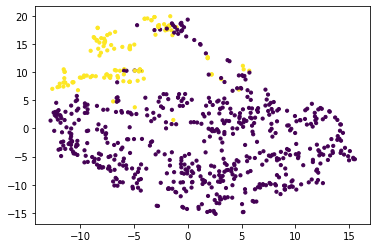

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_selected)

a = tsne_results[:,0]
b = tsne_results[:,1]
plt.scatter(a,b,c=y,s=10)

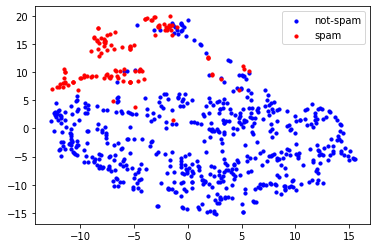

In [ ]:
df = pd.DataFrame()
df["a"] = a
df["b"] = b
df["y"] = y

aa = df[df.y==0]
bb = df[df.y==1]

plt.scatter(aa.a,aa.b,c="b",s=10,label="not-spam")
plt.scatter(bb.a,bb.b,c="r",s=10,label="spam")
plt.legend()
plt.savefig("tsnec2", bbox_inches='tight',dpi = 200)